In [2]:
# IMPORTS
import pickle
import os
import pandas as pd
import config
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from scipy.stats import linregress
from scipy.signal import savgol_filter
from scipy.signal import savgol_filter
np.__version__
import seaborn as sns
import pdb

In [3]:
# LOAD DATA
from datetime import datetime, timedelta
rr_perfs = np.load('sfn_stuff\\rr_perfs.npy')
lstm_perfs = np.load('sfn_stuff\\lstm_perfs.npy')
rr_perfs_across_days = np.load('sfn_stuff\\rr_perfs_across_days.npy')
lstm_perfs_across_days = np.load('sfn_stuff\\lstm_perfs_across_days.npy')

loaded_dates_np = np.load('sfn_stuff\\dates.npy')
dates = loaded_dates_np.astype('datetime64[ms]').astype(datetime)


In [4]:
### PLOT PREPARATION

# Convert dates to datetime objects
dates = [datetime.combine(date, datetime.min.time()) for date in dates]

# Calculate the number of days between each dataset
days = [(date - dates[0]).days for date in dates]

# Prepare RR data
rr_data = np.diagonal(rr_perfs, axis1=0, axis2=1) # Extract diagonal (same day performances)

# Prepare LSTM data (average across 3 models for each dataset)
num_datasets = lstm_perfs.shape[1]
models_per_dataset = lstm_perfs.shape[0] // num_datasets
degrees_of_freedom  = lstm_perfs.shape[2]

lstm_data_overall = []
for j in range(degrees_of_freedom):
    lstm_data = np.zeros([num_datasets])
    for i in range(num_datasets):
        lstm_data[i] = np.mean(lstm_perfs[i*models_per_dataset:i*models_per_dataset+models_per_dataset, i, j])
    lstm_data_overall.append(lstm_data)

lstm_data_overall = np.stack(lstm_data_overall)
# Prepare labels for subplots
dof_labels = ['First Finger Position', 'Second Finger Position', 'First Finger Velocity', 'Second Finger Velocity']


# PRINT NEW SHAPES
# print(np.array(dates).shape)
# print(rr_data.shape)
# print(np.array(lstm_data_overall).shape)



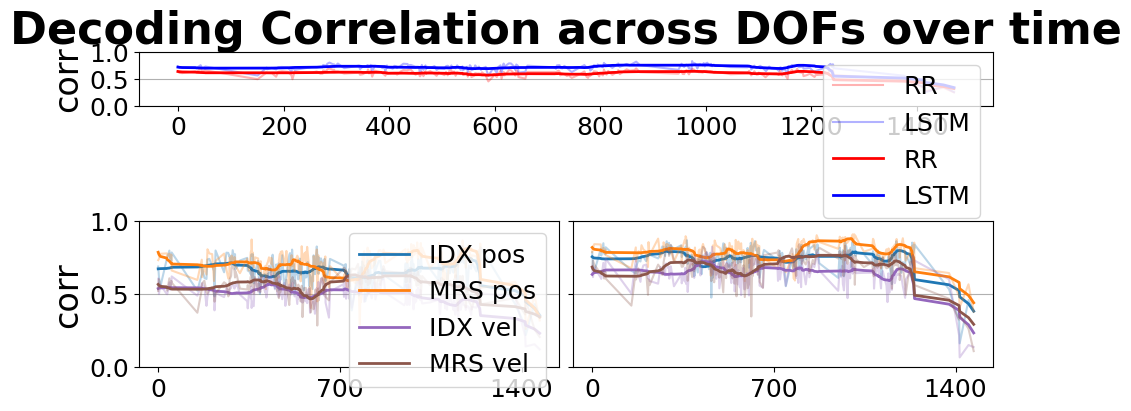

In [5]:
# PLOT SMOOTHED FIGURE

def smooth_data(x, y, method='savgol', window=51, poly_order=3):
    if method == 'savgol':
        return savgol_filter(y, window, poly_order)
    elif method == 'lowess':
        return lowess(y, x, frac=0.1, it=3)[:, 1]
    else:
        return y  # Return original data if no smoothing is specified
    

fig = plt.figure(figsize=(9.5, 4))
subfigs = fig.subfigures(2,1)
top_ax = subfigs[0].subplots(1,1)
dof_axs = subfigs[1].subplots(1,2, sharex=True, sharey=True)

# Convert dates to numerical values for smoothing
x = mdates.date2num(dates)
rr_smooth = []
lstm_smooth = []

labels = ('IDX pos','MRS pos','IDX vel','MRS vel')
colors = ('tab:blue','tab:orange','tab:purple','tab:brown')
def create_plot(data, ax):
    for i in range(data.shape[0]):
        data_sm = smooth_data(x, data[i,:], method='savgol')
        
        ax.plot(days, data[i,:], c=colors[i], alpha=0.3)
        ax.plot(days, data_sm, label=f'{labels[i]}', c=colors[i], lw=2)
        ax.set(ylim=(0,1))

create_plot(rr_data, dof_axs[0])
create_plot(lstm_data_overall, dof_axs[1])

mean_rr = np.mean(rr_data, axis=0)
mean_lstm = np.mean(lstm_data_overall, axis=0)

top_ax.plot(days, mean_rr, 'r-',alpha=0.3, label='RR')
top_ax.plot(days, mean_lstm, 'b-', alpha=0.3, label='LSTM')

rr_sm = smooth_data(x, mean_rr,  method='savgol')
lstm_sm = smooth_data(x, mean_lstm, method='savgol')

top_ax.plot(days, rr_sm, 'r-', label='RR', lw=2)
top_ax.plot(days, lstm_sm, 'b-', label='LSTM', lw=2)

top_ax.set(ylim=(0,1), title='Decoding Correlation across DOFs over time', yticks=(0,.5,1), ylabel='corr')
dof_axs[0].legend()

dof_axs[0].set(ylim=(0,1), yticks=(0,0.5,1), xticks=(0,700,1400), ylabel='corr')

top_ax.grid(True, axis='y')
top_ax.legend()
dof_axs[0].grid(True, axis='y')
dof_axs[1].grid(True, axis='y')

fig.savefig(os.path.join(config.characterizationdir, 'baseline_decode.pdf'))
plt.show()


# Performance Across Time Plots

In [6]:
def plot_perf_across_days(data_list, labels, colors, n_days_to_show = 1000):
    plt.figure(figsize=(10, 6))
    plt.ylabel("Correlation")
    plt.title("Average Performance Across Days")
    for data, label, color in zip(data_list, labels, colors):
        assert data.shape[0] < data.shape[1]
        
        nvals = np.sum(~np.isnan(data), axis = 0)
        threshold = 3
        inds = np.argwhere(nvals > threshold)
        plotting_data = data[:, inds]
        avgs = np.nanmean(plotting_data, axis = 0)
    
        plt.plot(inds, avgs, label = label, color = color)
        
        std = np.sqrt(np.nanvar(plotting_data, axis = 0))

        results = pd.DataFrame(np.stack((inds, avgs, std))[:,:,0].T, columns=['days','means','stds'])
        results.to_csv(os.path.join(config.characterizationdir,f"decode_res{label}.csv"))
        se = std
        plt.fill_between(inds[:, 0], (avgs-std)[:, 0], (avgs+std)[:, 0], color = color, alpha = .2)
  
    total_days = data.shape[1]//2
    step = 25
    start = total_days%step
    labels = [number - total_days for number in range(start, total_days*2-1, step)]
    plt.xticks(ticks = list(range(start, total_days*2-1, step)), labels=labels)
    plt.xlabel("Days since training")
    # plt.xlim([total_days-100, total_days+100])
    # plt.xlim([inds[0], inds[-1]])
    plt.xlim([total_days-n_days_to_show, total_days+n_days_to_show])
    plt.grid(True)
    plt.legend(loc = 'upper left')
    plt.savefig(os.path.join(config.characterizationdir, "perf_over_time.pdf"))

In [7]:
rr_avgs = np.mean(rr_perfs_across_days, axis = 2)
print(rr_avgs.shape[0]*rr_avgs.shape[1])
print(np.sum(np.nan))
lstm_avgs = np.mean(lstm_perfs_across_days, axis = 2)

744073
nan


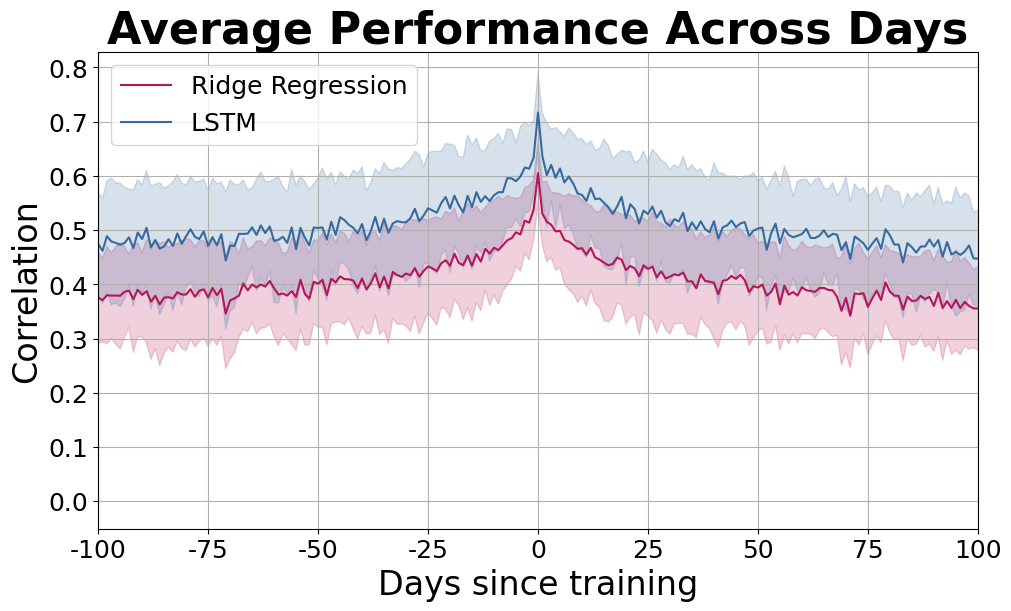

In [8]:
rr_c = sns.color_palette('rocket', as_cmap=True)(np.linspace(0,1,10))[2:7,:]
lstm_c = sns.color_palette('mako', as_cmap=True)(np.linspace(0,1,10))[2:7,:]
plot_perf_across_days([rr_avgs, lstm_avgs], ["Ridge Regression", "LSTM"], [rr_c[2,:], lstm_c[2,:]], 100)

In [9]:
rr_avgs

array([[       nan,        nan,        nan, ...,        nan,        nan,
        0.00191086],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.20987936,        nan,        nan, ...,        nan,        nan,
               nan]], shape=(253, 2941))

C:\Users\chang\AppData\Local\Temp\ipykernel_14508\363880913.py:5: RuntimeWarning: Degrees of freedom <= 0 for slice.
  variance = np.nanvar(data, axis = 0)


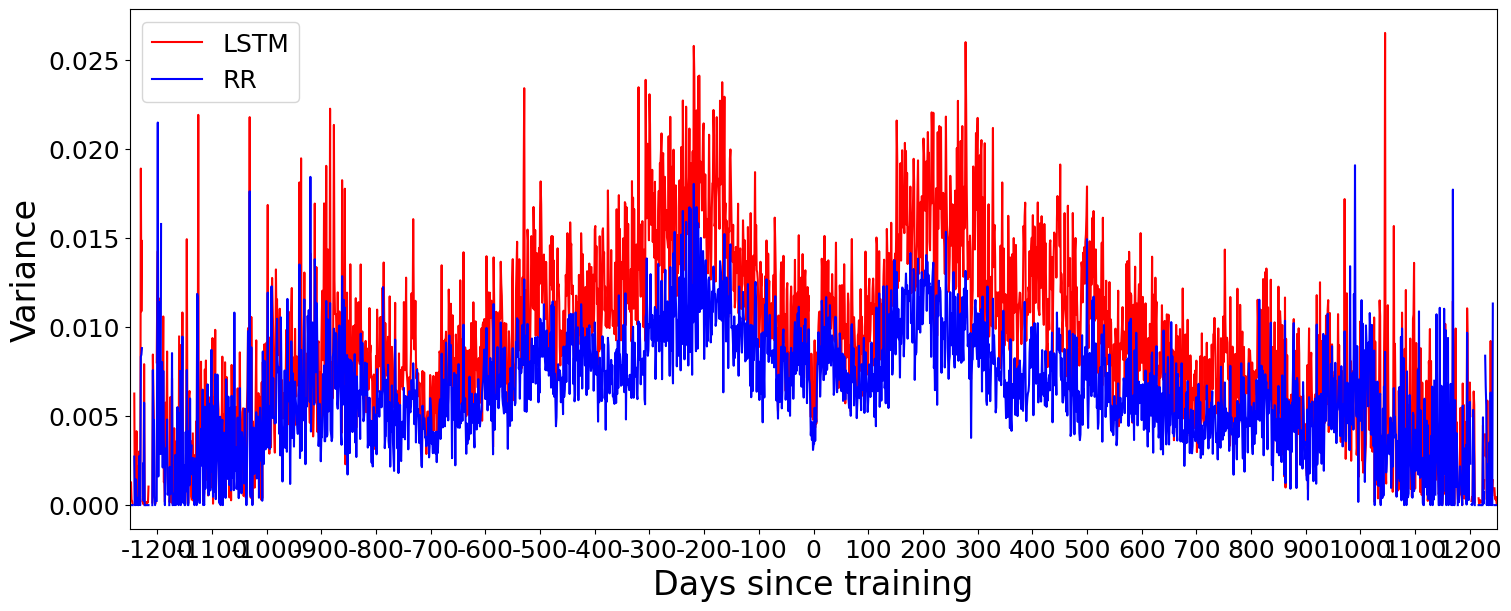

In [10]:
#Non-poster fig, used to inform days_to_show
def plot_variance(data_list, labels, colors):
    plt.figure(figsize=(15, 6))
    for data, label, color in zip(data_list, labels, colors):
        variance = np.nanvar(data, axis = 0)
        plt.plot(variance, color = color, label = label)
        plt.ylabel("Variance")
    
    total_days = data.shape[1]//2
    step = 100
    start = total_days%step
    labels = [number - total_days for number in range(start, total_days*2-1, step)]
    plt.xticks(ticks = list(range(start, total_days*2-1, step)), labels=labels)
    plt.xlim([total_days-1250, total_days+1250])
    plt.xlabel("Days since training")
    plt.legend()
    
        
plot_variance([lstm_avgs, rr_avgs], ["LSTM", "RR"], ["Red", "Blue"])

In [11]:
def make_histograms(data_list, labels, colors, days_to_show):
    fig, axs = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10, 6))
    ndata = len(data_list)
    plt.suptitle("KDE of Performance at Day K")

    
    for i, data in enumerate(data_list):
        print(i)
        day_0 = data.shape[1]//2

        sns.kdeplot(data[:, day_0], color = colors[i][0,:], label = 0, ax=axs[i,0])
        plt.xlim([0, 1])
        plt.xlabel("Correlation")
        # if i ==0:
        #     plt.title("Backward in time")
        sns.kdeplot(data[:, day_0], color = colors[i][0,:], label = 0, ax=axs[i,1])
        plt.xlim([0, 1])
        # if i ==0:
        #     plt.title("Forward in time")
        plt.xlabel("Correlation")


        for j, day in enumerate(days_to_show):
            sns.kdeplot(data[:, day_0-day], color = colors[i][j+1,:], label = day, ax=axs[i,0])
            plt.subplot(ndata, 2, 2+(i*2))
            sns.kdeplot(data[:, day_0+day], color = colors[i][j+1,:], label = day, ax=axs[i,1])
    
    axs[0,0].legend()
    axs[1,0].legend()
    axs[0,0].grid(True)
    axs[0,1].grid(True)
    axs[1,1].grid(True)
    axs[1,0].grid(True)
    fig.savefig(os.path.join(config.characterizationdir,"kde_decodes.pdf"))


0
1


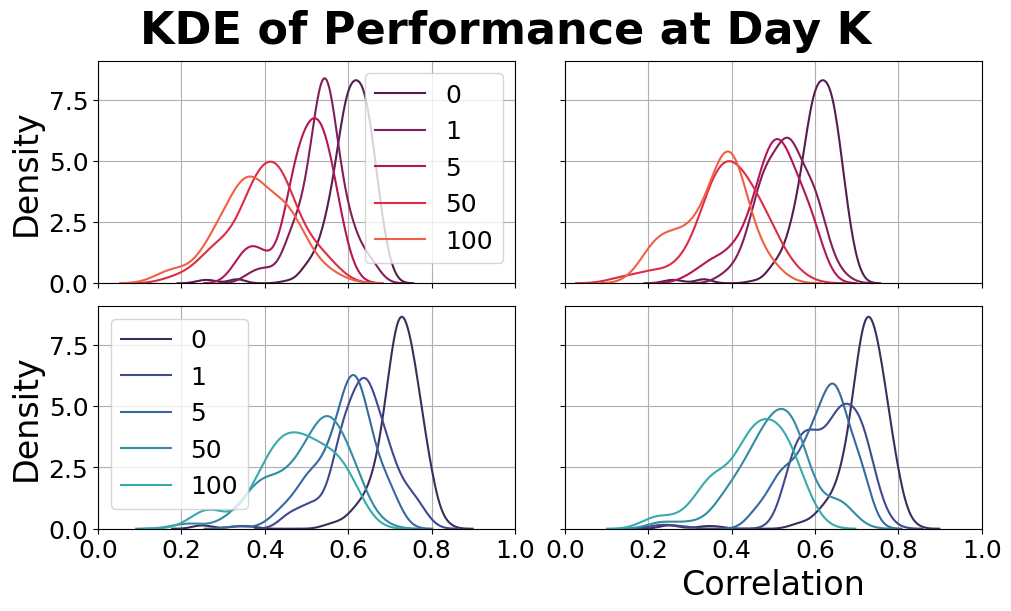

In [12]:
# make_histograms_2([rr_avgs, lstm_avgs], ["RR", "LSTM"], ["Red", "Blue"], [250, 450, 800])
rr_c = sns.color_palette('rocket', as_cmap=True)(np.linspace(0,1,10))[2:7,:]
lstm_c = sns.color_palette('mako', as_cmap=True)(np.linspace(0,1,10))[2:7,:]
make_histograms([rr_avgs, lstm_avgs], ["Ridge Regression", "LSTM"], [rr_c, lstm_c], [1, 5, 50, 100])


In [13]:
import seaborn as sns
def make_histograms_2(data_list, labels, colors, days_to_show):
    plt.figure(figsize=(10, 6))
    ndata = len(data_list)
    alphas = np.linspace(1, .3, len(days_to_show)+1)
    plt.suptitle("Kernel Density Estimation of Performance at Day K")
    for i, data in enumerate(data_list):
        day_0 = data.shape[1]//2
        plt.subplot(1, 2, 1)
        sns.kdeplot(data[:, day_0], color = colors[i], label = f"Day 0 {labels[i]}", alpha = alphas[0])
        plt.xlim(0, 1)
        plt.xlabel("Correlation")
        plt.subplot(1, 2, 2)
        sns.kdeplot(data[:, day_0], color = colors[i], label = f"Day 0 {labels[i]}", alpha = alphas[0])
        plt.xlim(0, 1)
        plt.xlabel("Correlation")

        for j, day in enumerate(days_to_show):
            plt.subplot(1, 2, 1)
            sns.kdeplot(data[:, day_0-day], color = colors[i], label = f"Day -{day} {labels[i]}", alpha = alphas[j+1])
            plt.subplot(1, 2, 2)
            sns.kdeplot(data[:, day_0+day], color = colors[i], label = f"Day {day} {labels[i]}", alpha = alphas[j+1])
    
    plt.subplot(1, 2, 1)    
    plt.legend()
    plt.subplot(1, 2, 2)    
    plt.legend()